# Импорт пакетов

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import joblib

from tqdm._tqdm_notebook import tqdm_notebook

<ipython-input-1-3b6305beb9ba>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


# Загрузка данных

In [2]:
PATH_DATA = './data'
MODEL_PATH = "model.pkl"

In [3]:
# Считываем данные
tr_mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
tr_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), index_col='client_id')

gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), index_col='client_id')
gender_train.drop(columns=['Unnamed: 0'], inplace=True, axis=1)
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), index_col='client_id')
gender_test.drop(columns=['Unnamed: 0'], inplace=True, axis=1)

transactions_with_gender_train = transactions.join(gender_train, how='inner', on='client_id')
transactions_with_gender_test = transactions.join(gender_test, how='inner', on='client_id')

mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
trans_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions_with_mcc_train = transactions_with_gender_train.join(mcc_codes, how='inner', on='mcc_code')
transactions_with_mcc_test = transactions_with_gender_test.join(mcc_codes, how='inner', on='mcc_code')

transactions_train_0 = transactions_with_mcc_train.join(trans_types, how='inner', on='trans_type')
transactions_test_0 = transactions_with_mcc_test.join(trans_types, how='inner', on='trans_type')

tr_mcc_categories = pd.read_csv(os.path.join(PATH_DATA, 'mcc_categories.csv'), sep=';', index_col='mcc_code')

transactions_train = transactions_train_0.join(tr_mcc_categories, how='inner', on='mcc_code')
transactions_test = transactions_test_0.join(tr_mcc_categories, how='inner', on='mcc_code')

In [4]:
transactions_train

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,gender,mcc_description,trans_description,mcc_category
client_id,,,,,,,,,,
d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829.0,2370.0,-1808.56,NaN,Tver,0,Денежные переводы,Списание с карты на карту по операции <перевод...,Финансы
d1bbbc9a0e0410d3cf12a3d2f44f3450,105 12:57:32,4829.0,2370.0,-3390.41,NaN,Tver,0,Денежные переводы,Списание с карты на карту по операции <перевод...,Финансы
d1bbbc9a0e0410d3cf12a3d2f44f3450,74 14:29:42,4829.0,2370.0,-6155.97,NaN,Tver,0,Денежные переводы,Списание с карты на карту по операции <перевод...,Финансы
d1bbbc9a0e0410d3cf12a3d2f44f3450,119 15:01:24,4829.0,2370.0,-1447.13,NaN,Tver,0,Денежные переводы,Списание с карты на карту по операции <перевод...,Финансы
d1bbbc9a0e0410d3cf12a3d2f44f3450,17 09:40:16,4829.0,2370.0,-724.03,NaN,Tver,0,Денежные переводы,Списание с карты на карту по операции <перевод...,Финансы
...,...,...,...,...,...,...,...,...,...,...
982f4a5229f43d8b02f15848c34dfb67,427 10:03:06,6011.0,7015.0,3616.60,388913,Tver,1,Финансовые институты — снятие наличности автом...,Взнос наличных через АТМ (в других ТБ) по счет...,Финансы
00f2a9f3eef2bc319e350ab3d6a2de09,247 13:08:54,6011.0,7015.0,1012.34,362429,Novosibirsk,0,Финансовые институты — снятие наличности автом...,Взнос наличных через АТМ (в других ТБ) по счет...,Финансы
ebb98af36a90a31334ffc4e12f67d182,272 11:29:59,6011.0,7015.0,3903.94,895128,Kaliningrad,1,Финансовые институты — снятие наличности автом...,Взнос наличных через АТМ (в других ТБ) по счет...,Финансы


# EDA

In [5]:
transactions_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1354904 entries, d1bbbc9a0e0410d3cf12a3d2f44f3450 to 94b1adf7155ae09b73203e34dbe171a1
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   trans_time         1354904 non-null  object 
 1   mcc_code           1354904 non-null  float64
 2   trans_type         1354904 non-null  float64
 3   amount             1354904 non-null  float64
 4   term_id            805709 non-null   object 
 5   trans_city         1354904 non-null  object 
 6   gender             1354904 non-null  int64  
 7   mcc_description    1354904 non-null  object 
 8   trans_description  1354904 non-null  object 
 9   mcc_category       1354904 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 113.7+ MB


In [6]:
transactions_train.describe(include='object')

,trans_time,term_id,trans_city,mcc_description,trans_description,mcc_category
count,1354904,805709,1354904,1354904,1354904,1354904
unique,1201116,186625,10,184,62,22
top,291 23:59:50,888991,Kaliningrad,Финансовые институты — снятие наличности автом...,Покупка. POS ТУ СБ РФ,Финансы
freq,20,14672,164768,289760,321610,598652


In [7]:
transactions_train.describe(include=['int64', 'float64'])

,mcc_code,trans_type,amount,gender
count,1.354904e+06,1.354904e+06,1.354904e+06,1.354904e+06
mean,5.589350e+03,2.445477e+03,-6.975686e+02,4.809787e-01
std,6.049196e+02,2.221720e+03,1.738957e+04,4.996382e-01
min,7.420000e+02,1.000000e+03,-4.338732e+06,0.000000e+00
25%,5.211000e+03,1.030000e+03,-7.225600e+02,0.000000e+00
50%,5.641000e+03,1.110000e+03,-1.831400e+02,0.000000e+00
75%,6.010000e+03,2.370000e+03,-3.704000e+01,1.000000e+00
max,9.402000e+03,8.146000e+03,2.169367e+06,1.000000e+00


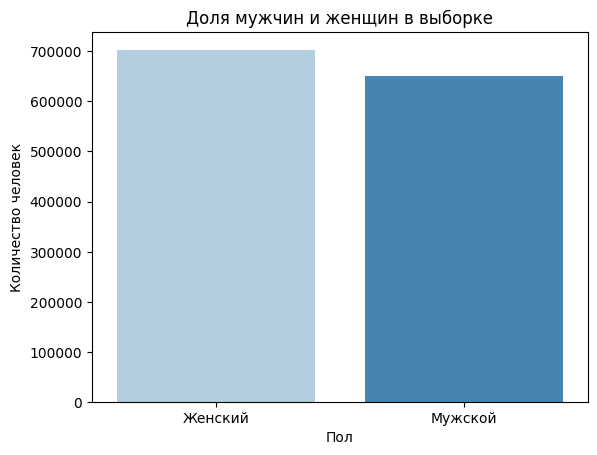

In [8]:
sns.countplot(x ='gender', data=transactions_train, palette='Blues')
plt.xticks([0,1], ['Женский', 'Мужской'])
plt.title('Доля мужчин и женщин в выборке')
plt.ylabel('Количество человек')
plt.xlabel('Пол')
plt.show()

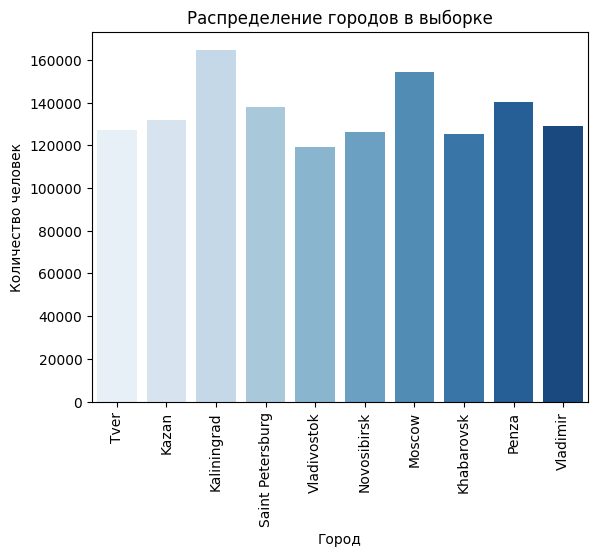

In [9]:
sns.countplot(x ='trans_city', data=transactions_train, palette='Blues')
plt.xticks(rotation=90)
plt.title('Распределение городов в выборке')
plt.ylabel('Количество человек')
plt.xlabel('Город')
plt.show()

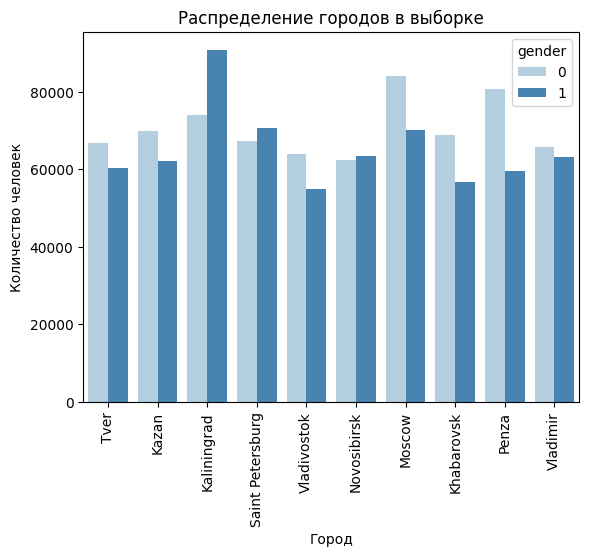

In [10]:
sns.countplot(x ='trans_city', data=transactions_train, hue='gender', palette='Blues')
plt.xticks(rotation=90)
plt.title('Распределение городов в выборке')
plt.ylabel('Количество человек')
plt.xlabel('Город')
plt.show()

In [11]:
trans_code_to_type = {'1': 'покупки', '2': 'переводы',
                      '4': 'банковские услуги',
                      '6': 'возвраты', '7': 'взнос наличных и пополенения',
                      '8': 'прочее'}

transactions_train['trans_type_new'] = [trans_code_to_type[str(i)[0]] for i in transactions_train['trans_type']]

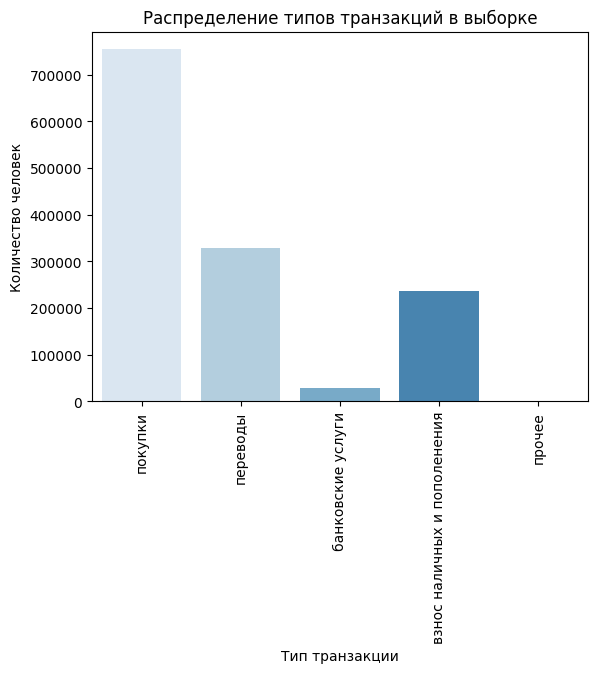

In [12]:
sns.countplot(x ='trans_type_new', data=transactions_train, palette='Blues',
             order = ['покупки', 'переводы', 'банковские услуги',
                      'взнос наличных и пополенения', 'прочее'])
plt.xticks(rotation=90)
plt.title('Распределение типов транзакций в выборке')
plt.ylabel('Количество человек')
plt.xlabel('Тип транзакции')
plt.show()

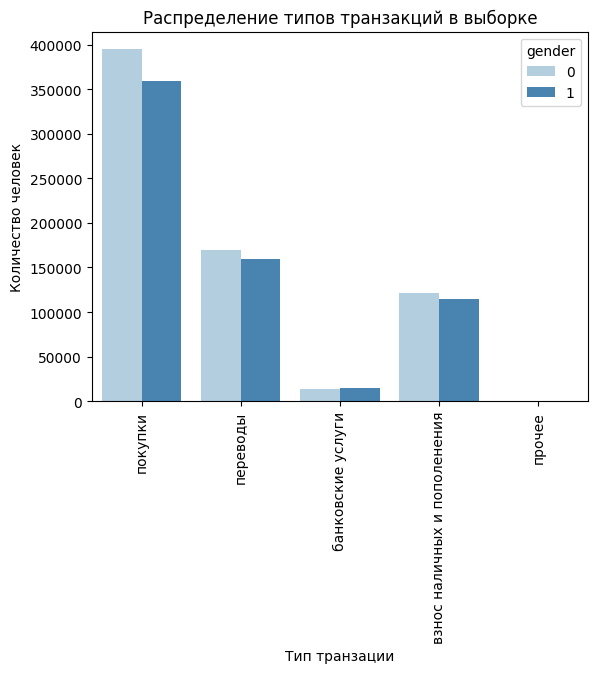

In [13]:
sns.countplot(x ='trans_type_new', hue='gender', data=transactions_train, palette='Blues',
             order = ['покупки', 'переводы', 'банковские услуги',
                      'взнос наличных и пополенения', 'прочее'])
plt.xticks(rotation=90)
plt.title('Распределение типов транзакций в выборке')
plt.ylabel('Количество человек')
plt.xlabel('Тип транзации')
plt.show()

In [14]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

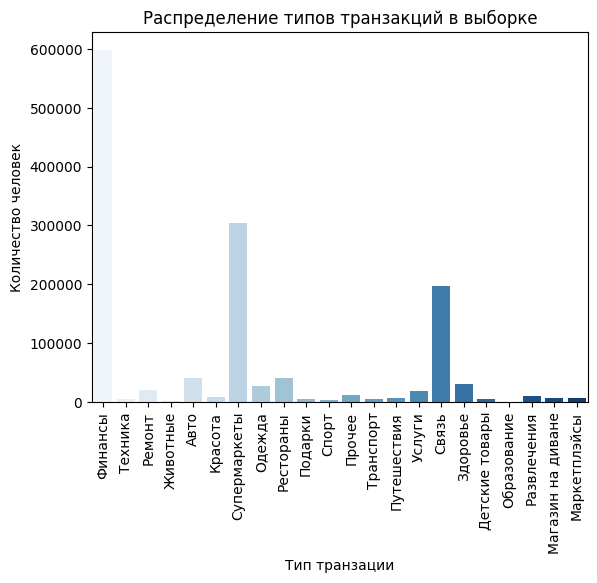

In [15]:
sns.countplot(x ='mcc_category', data=transactions_train, palette='Blues')
plt.xticks(rotation=90)
plt.title('Распределение типов транзакций в выборке')
plt.ylabel('Количество человек')
plt.xlabel('Тип транзации')
plt.show()

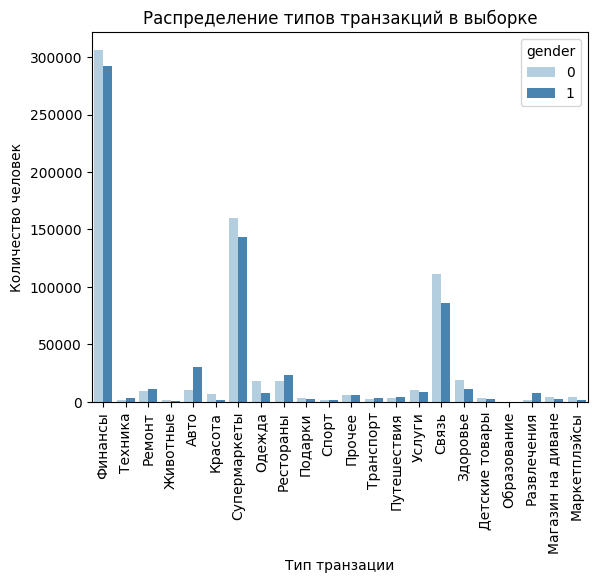

In [16]:
sns.countplot(x ='mcc_category', hue='gender', data=transactions_train, palette='Blues')
plt.xticks(rotation=90)
plt.title('Распределение типов транзакций в выборке')
plt.ylabel('Количество человек')
plt.xlabel('Тип транзации')
plt.show()

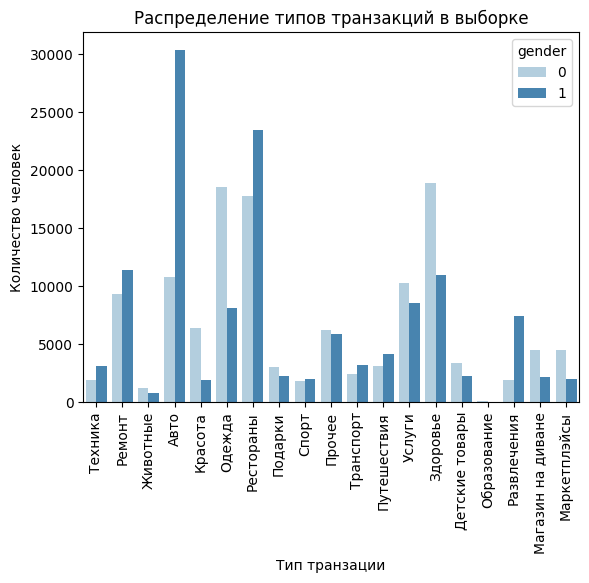

In [17]:
sns.countplot(x ='mcc_category', hue='gender', data=transactions_train[(transactions_train['mcc_category']!='Финансы') & (transactions_train['mcc_category']!='Супермаркеты') & (transactions_train['mcc_category']!='Связь')], palette='Blues')
plt.xticks(rotation=90)
plt.title('Распределение типов транзакций в выборке')
plt.ylabel('Количество человек')
plt.xlabel('Тип транзации')
plt.show()

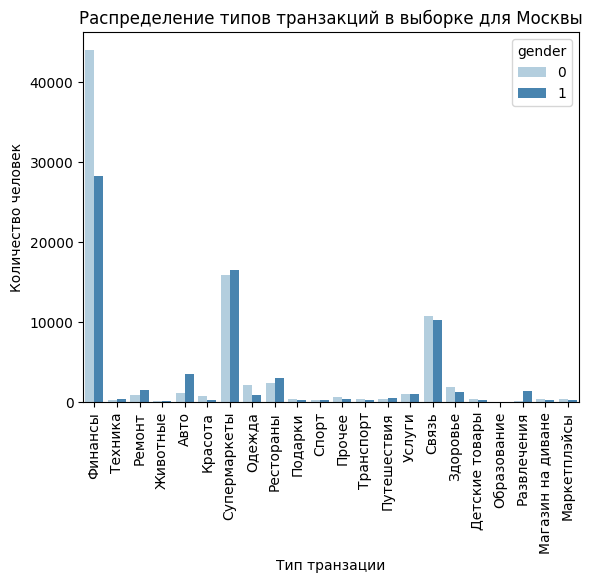

In [18]:
sns.countplot(x ='mcc_category', hue='gender', data=transactions_train[transactions_train['trans_city']=='Moscow'], palette='Blues')
plt.xticks(rotation=90)
plt.title('Распределение типов транзакций в выборке для Москвы')
plt.ylabel('Количество человек')
plt.xlabel('Тип транзации')
plt.show()

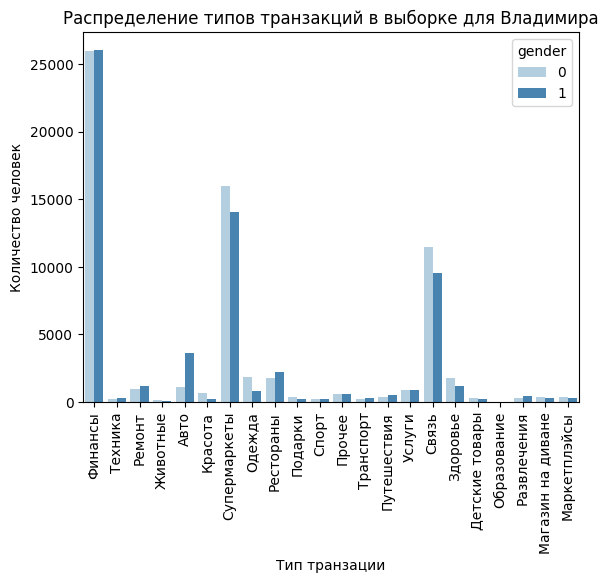

In [19]:
sns.countplot(x ='mcc_category', hue='gender', data=transactions_train[transactions_train['trans_city']=='Vladimir'], palette='Blues')
plt.xticks(rotation=90)
plt.title('Распределение типов транзакций в выборке для Владимира')
plt.ylabel('Количество человек')
plt.xlabel('Тип транзации')
plt.show()

In [20]:
# Группировка данных по пользователям и категориям трат
grouped = transactions_train.groupby([transactions_train.index, 'mcc_category', 'gender'])
total_spending = grouped['amount'].sum()

In [21]:
total_spending

client_id                         mcc_category    gender
0002cf30347684df542e1a931f356875  Детские товары  0          -2298.13
                                  Здоровье        0          -5612.06
                                  Красота         0          -1255.95
                                  Одежда          0          -9049.54
                                  Подарки         0          -1535.18
                                                              ...    
fffbed6c440a05e5593ad1a865e586a8  Транспорт       1            -72.59
                                  Финансы         1          18302.99
fffedf876a0ea3d39e54b706165a4826  Связь           1            -73.12
                                  Супермаркеты    1           -123.92
                                  Финансы         1        -146207.62
Name: amount, Length: 64474, dtype: float64

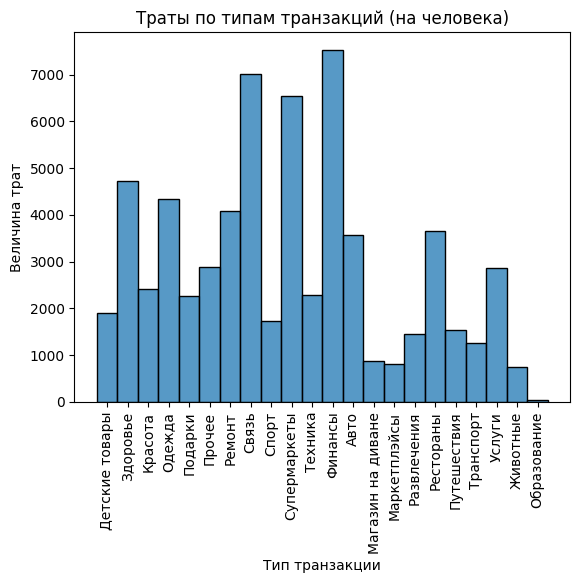

In [22]:
sns.histplot(x ='mcc_category', data=total_spending)
plt.xticks(rotation=90)
plt.title('Траты по типам транзакций (на человека)')
plt.ylabel('Величина трат')
plt.xlabel('Тип транзакции')
plt.show()

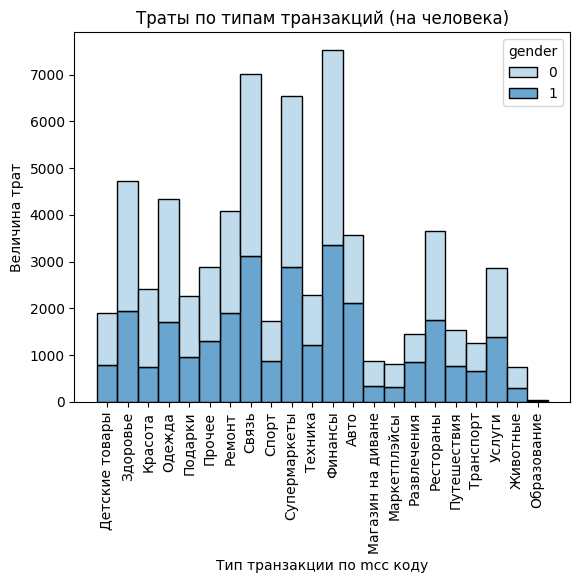

In [23]:
sns.histplot(x='mcc_category', hue='gender', data=total_spending, multiple="stack", palette='Blues')
plt.xticks(rotation=90)
plt.title('Траты по типам транзакций (на человека)')
plt.ylabel('Величина трат')
plt.xlabel('Тип транзакции по mcc коду')
plt.show()

## Feature engineering

In [24]:
for df in [transactions_train, transactions_test]:
    df['weekday'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 7)
    df['month'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) // 30)
    df['hour'] = df['trans_time'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = df['hour'].between(0, 5).astype(int)
    df['morning'] = df['hour'].between(6, 11).astype(int)
    df['afternoon'] = df['hour'].between(12, 17).astype(int)
    df['evening'] = df['hour'].between(18, 23).astype(int)

In [25]:
for df in [transactions_train, transactions_test]:
    for category in pd.unique(df['mcc_category']):
        df[category] = df['mcc_category'].isin([category])

    df['trans_type_new'] = [trans_code_to_type[str(i)[0]] for i in df['trans_type']]

In [26]:
def features_creation(x):
    features = []
    features.append(pd.Series(x['amount'].agg(['min', 'max', 'median', 'std', 'sum'])\
                                                        .add_prefix('negative_transactions_')))

    for time in ['weekday', 'month', 'hour', 'night']:
        features.append(pd.Series(x[x[time] == True]['amount'].agg(['min', 'mean','count'])\
                                                        .add_prefix(f'{time}_')))

    for category in ['Авто', 'Одежда', 'Красота', 'Рестораны', 'Здоровье', 'Супермаркеты', 'Связь', 'Техника', 'Ремонт', 'Услуги', 'Магазин на диване', 'Маркетплэйсы']:
        features.append(pd.Series(x[x['mcc_category'] == category]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix(f'{category}_')))

    return pd.concat(features)

In [27]:
data_train = transactions_train.groupby(transactions_train.index).apply(features_creation)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation)

for df in [data_train, data_test]:
    df['total_sum'] = df['Авто_sum'] + df['Одежда_sum'] + df['Красота_sum'] + \
    df['Рестораны_sum'] + df['Здоровье_sum'] + df['Супермаркеты_sum'] + df['Супермаркеты_sum'] + \
    df['Связь_sum'] + df['Техника_sum'] + df['Ремонт_sum'] + df['Услуги_sum'] + \
    df['Магазин на диване_sum'] + df['Маркетплэйсы_sum']

for df in [data_train, data_test]:
    for cat in ['Авто', 'Одежда', 'Красота', 'Рестораны', 'Здоровье', 'Супермаркеты', 'Связь',
                'Техника', 'Ремонт', 'Услуги', 'Магазин на диване', 'Маркетплэйсы']:
        df[f'{cat}_perc'] =  df[f'{cat}_sum'] / df['total_sum']

# Model fitting

In [28]:
def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True,
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)),
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])

    joblib.dump(clf, MODEL_PATH)
    return clf, submission

In [29]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,

    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

In [30]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

# Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации
clf, submission = fit_predict(params, 97, data_train, data_test, target)

submission.to_csv('result.csv')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:00:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.829+-0.015, Trees: 147


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:00:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
